In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

from skimage.transform import resize
%matplotlib inline

In [2]:
import torch
from torch.nn.functional import upsample

In [3]:
import h5py

D:\Anaconda3\envs\pytorch\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [37]:
from SRNetEval import vis_vf,mse, norm_mse

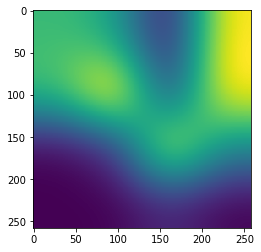

In [21]:

plt.figure()
plt.imshow(mu_maps[4])

# Porosity Dataset

In [59]:
# Generate Training Data
def upsize_alpha(alpha,out=64):
    insize = alpha.shape[0]
    pad_alpha = np.pad(alpha[1:-1,1:-1],([1,1],[1,1]),'edge')
    
    uf = int(out/4)
    df = int(insize/4)
    
    up_alpha = np.kron(pad_alpha[::df,::df],np.ones((uf,uf)))
    return np.pad(up_alpha[1:-1,1:-1],((1,1),(1,1)),'constant')
    

In [7]:
basepath = '../Porosity/data2/'
lr = sio.loadmat(basepath+'U16_1.mat')
print([key for key in lr.keys()])
hr = sio.loadmat(basepath+'U256_1.mat')
print([key for key in hr.keys()])

['__header__', '__version__', '__globals__', 'Pl', 'Ul', 'Vl', 'alpha1']
['__header__', '__version__', '__globals__', 'Ph', 'Uh', 'Vh']


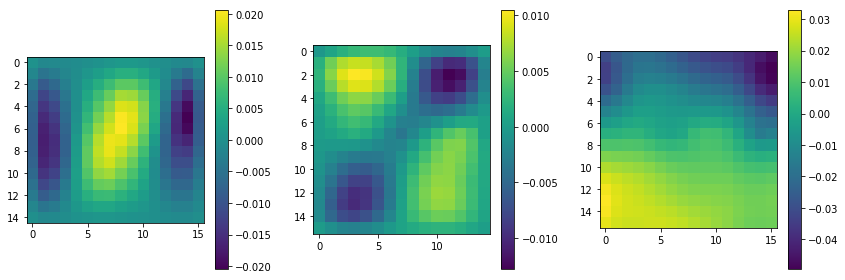

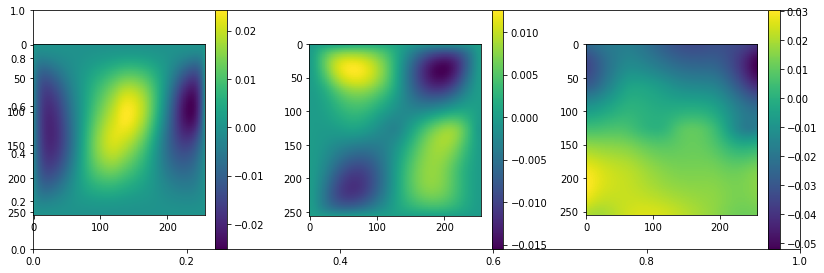

In [13]:
fig1 = plt.figure(figsize=(12,4))
fig2 = plt.figure(figsize=(12,4))
for i,c in enumerate(['U','V','P'],1):
    ax = fig1.add_subplot(1,3,i)
    cb = ax.imshow(lr[c+'l'])
    plt.colorbar(cb,ax=ax)
    ax = fig2.add_subplot(1,3,i)
    cb = ax.imshow(hr[c+'h'])
    plt.colorbar(cb,ax=ax)
fig1.tight_layout()
fig2.tight_layout()

In [14]:
lr_data = np.zeros((500,4,16,16))
hr_data = np.zeros((500,3,256,256))

In [18]:
for i in range(500):
    # read in data
    lr = sio.loadmat(basepath+'U16_'+str(i+1)+'.mat')
    hr = sio.loadmat(basepath+'U256_'+str(i+1)+'.mat')
    
    # load channels
    for j,c in enumerate(['U','V','P']):
        lr_data[i,j,...] = resize(lr[c+'l'],[16,16])
        hr_data[i,j,...] = resize(hr[c+'h'],[256,256])
    
    # Add porosity
    lr_data[i,-1,...] = lr['alpha1']

D:\Anaconda3\envs\pytorch\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [20]:
# Normalize data
nlr_data = lr_data.copy()
nhr_data = hr_data.copy()
for j,c in enumerate(['U','V','P']):
    nlr_data[:,j] /= nlr_data[:,j].max()
    nhr_data[:,j] /= nhr_data[:,j].max()

In [22]:
# Compare Raw MSE from upsampling
lr_up = upsample(torch.Tensor(lr_data),scale_factor=16,mode='bilinear').numpy()
nlr_up = upsample(torch.Tensor(nlr_data),scale_factor=16,mode='bilinear').numpy()


D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [44]:
avg_img = lr_up.mean(axis=0)
mse1 = np.power(lr_up[:,:-1]-hr_data,2).mean(axis=(-2,-1))
norm = np.power(hr_data,2).mean(axis=(-2,-1))
avgmse = np.power(hr_data-avg_img[:-1],2).mean(axis=(-2,-1))
print(mse1.mean(),np.sqrt((mse1/norm).mean()),np.sqrt((avgmse/norm).mean()))

navg_img = nlr_up.mean(axis=0)
nmse1 = np.power(nlr_up[:,:-1]-nhr_data,2).mean(axis=(-2,-1))
nnorm = np.power(nhr_data,2).mean(axis=(-2,-1))
navgmse = np.power(nhr_data-navg_img[:-1],2).mean(axis=(-2,-1))
print(nmse1.mean(),np.sqrt((nmse1/nnorm).mean()),np.sqrt((navgmse/nnorm).mean()))
# mse1 = np.array([mse(lr_up[i,:-1,...],hr_data[i,...]) for i in range(500)])
# mse2 = np.array([norm_mse(lr_up[i,:-1,...],hr_data[i,...]) for i in range(500)])
# mse3 = np.array([norm_mse(avg_img,hr_data[i,...]) for i in range(500)])
# nmse1 = np.array([mse(nlr_up[i,:-1,...],nhr_data[i,...]) for i in range(500)])
# nmse2 = np.array([norm_mse(nlr_up[i,:-1,...],nhr_data[i,...]) for i in range(500)])
# nmse3 = np.array([norm_mse(navg_img,nhr_data[i,...]) for i in range(500)])


# print(mse1.mean(),mse2.mean(),mse3.mean())
# print(nmse1.mean(),nmse2.mean(),nmse3.mean())

4.23395197788425e-06 0.18163254008825166 0.7399762578534529
0.0016395879537664533 0.15771889724862462 0.7720634482675219


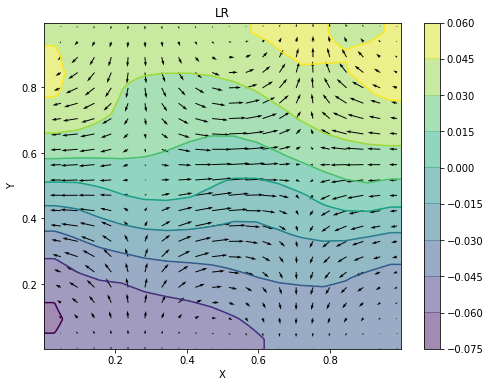

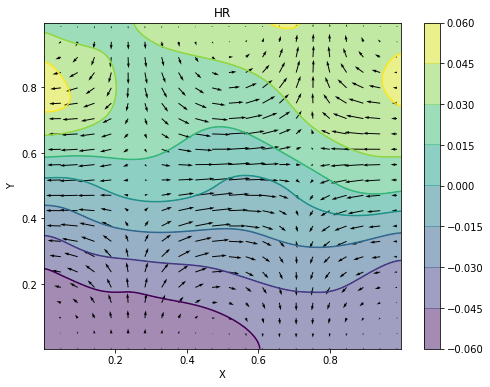

In [36]:
idx = 10
U,V,P = lr_up[idx,:-1,...]
vis_vf(U,V,P,title='LR')
U,V,P = hr_data[idx,...]
vis_vf(U,V,P,title='HR')

In [60]:
# Create Training data
bil_data = np.zeros((500,4,64,64))

In [63]:
bil_data[:,:-1,...] = upsample(torch.Tensor(nlr_data[:,:-1,...]),scale_factor=4,mode='bilinear').numpy()
bil_data[:,-1,...] = np.array([upsize_alpha(alpha) for alpha in nlr_data[:,-1,...]])
labels = nhr_data[:,:,::4,::4]-bil_data[:,:-1,...]

D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [64]:
# hf = h5py.File('Porosity16_Train.h5','w')
# hf.create_dataset('training_data', data=bil_data[:400], compression="gzip")
# hf.create_dataset('training_labels', data=labels[:400], compression="gzip")

# hf.close()

# hf = h5py.File('Porosity16_Test.h5','w')
# hf.create_dataset('training_data', data=bil_data[400:], compression="gzip")
# hf.create_dataset('training_labels', data=labels[400:], compression="gzip")

# hf.close()

In [65]:
hf = h5py.File('Porosity16_data.h5','w')
hf.create_dataset('training_data',data=nlr_data[:,:-1,...],compression='gzip')
hf.create_dataset('training_labels',data=nhr_data,compression='gzip')
hf.create_dataset('alphas',data=nlr_data[:,-1],compression='gzip')
hf.close()

In [68]:
1/np.power(10,np.arange(6,10))

array([1.e-06, 1.e-07, 1.e-08, 1.e-09])

# Convert HF 256->64

In [4]:
def down_mu2(mu,factor=2):
    dmu = mu[...,1:-1,1:-1]
    dmu = dmu[...,::factor,::factor]
    return dmu
    pad_width = [(0,0) for i in range(mu.ndim)]
    pad_width[-1] = (1,1)
    pad_width[-2] = (1,1)
    return np.pad(dmu,pad_width=pad_width,mode='reflect')

In [10]:
hf = h5py.File('sr16_data.h5','r')
print([key for key in hf.keys()])
lr_data = hf['training_data'][()]
hr_data = hf['training_labels'][()]
mu_maps = hf['mu_maps'][()]
hf.close()

factor = 4

['mu_maps', 'training_data', 'training_labels']


In [11]:
# Upsample lr data from 16x16 to 128x128
training_data = upsample(torch.Tensor(lr_data),scale_factor=int((256/factor)/16),mode='bilinear').numpy()

D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [12]:
# Downsample hr data to 128x128, subtract training_data
training_labels = hr_data[...,::factor,::factor] - training_data #[...,::2,::2]-training_data

# Downsample mu_maps
down_mu = down_mu2(mu_maps,factor)[:,np.newaxis,...]
#down_mu = mu_maps[:,np.newaxis,1:-1,1:-1] #= 
print (training_data.shape, down_mu.shape)
training_data = np.concatenate((training_data,down_mu),axis=1)
print(training_data.shape)

# Combine training data and mu maps

(1000, 3, 64, 64) (1000, 1, 64, 64)
(1000, 4, 64, 64)


In [13]:
# hf = h5py.File('hf16_train_64.h5','w')
# hf.create_dataset('training_data', data=training_data[:800,...], compression="gzip")
# hf.create_dataset('training_labels', data=training_labels[:800,...], compression="gzip")
# hf.close()

# hf = h5py.File('hf16_test_64.h5','w')
# hf.create_dataset('training_data', data=training_data[800:,...], compression="gzip")
# hf.create_dataset('training_labels', data=training_labels[800:,...], compression="gzip")
# hf.close()

### Check Error from upsampling step

In [14]:
print(np.power(training_labels,2).mean())

0.053602151682128125


In [25]:
factor = 2
bil = upsample(torch.Tensor(hr_data[...,::factor,::factor]),scale_factor=factor,mode='bilinear').numpy()
bil -= hr_data

print(np.power(bil,2).mean(axis=(0,-1,-2)))
print(np.sqrt(np.power(bil,2).mean()/np.power(hr_data,2).mean()))

D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


[6.0645401e-05 6.8421738e-05 3.4300516e-05]
0.017108302621423654


In [26]:
factor = 4
bil = upsample(torch.Tensor(hr_data[...,::factor,::factor]),scale_factor=factor,mode='bilinear').numpy()
bil -= hr_data

print(np.power(bil,2).mean(axis=(0,-1,-2)))
print(np.sqrt(np.power(bil,2).mean()/np.power(hr_data,2).mean()))

D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


[0.00054506 0.00060692 0.0003065 ]
0.05111798086952838


In [24]:
bil = upsample(torch.Tensor(lr_data),scale_factor=16,mode='bilinear').numpy()
bil -= hr_data

print(np.power(bil,2).mean(axis=(0,-1,-2)))
print(np.sqrt(np.power(bil,2).mean()/np.power(hr_data,2).mean()))

D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


[0.03825732 0.03999235 0.08492699]
0.5406968525002871


# Ali Code

In [6]:
path = './FullFlow_data/U_hr1.mat'

In [7]:
matdata = sio.loadmat(path)
print([key for key in matdata])

['__header__', '__version__', '__globals__', 'U_hr']


In [13]:
data = matdata['U_hr']
U,V,P = data[0]

In [14]:
U.shape,V.shape,P.shape

((90, 91), (91, 90), (91, 91))

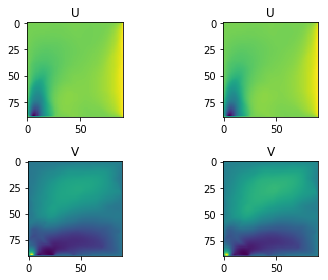

In [79]:
plt.subplot(221)
plt.imshow(U)
plt.title('U')

plt.subplot(222)
plt.imshow(vavg(U.T).T)
plt.title('U')

plt.subplot(223)
plt.imshow(V)
plt.title('V')

plt.subplot(224)
plt.imshow(vavg(V))
plt.title('V')
plt.tight_layout()

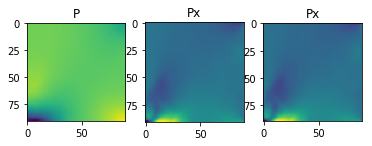

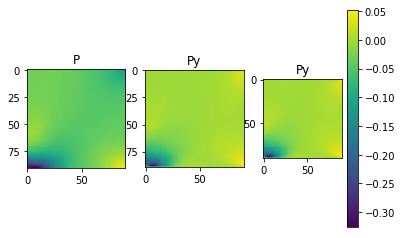

In [94]:
plt.figure()
plt.subplot(131)
plt.imshow(P)
plt.title('P')

Px = vdif(P.T).T
plt.subplot(132)
plt.imshow(Px)
plt.title('Px')

plt.subplot(133)
plt.imshow(vavg(Px))
plt.title('Px')

plt.figure()
plt.subplot(131)
plt.imshow(P)
plt.title('P')

Py = vdif(P)
plt.subplot(132)
plt.imshow(Py)
plt.title('Py')

plt.subplot(133)
plt.imshow(vavg(Py.T).T)
plt.title('Py')
plt.colorbar()

In [91]:
P.shape, vdif(P.T).shape, vavg(vdif(P.T).T).shape

((91, 91), (90, 91), (90, 90))

In [86]:
def vavg(x):
    return (x[1:,:] + x[:-1,:])/2
def vdif(x):
    return (x[1:,:] - x[:-1,:])

### Cycle through data

In [83]:
basepath = './PDE_Data/Upde_hr'

HR_data = np.zeros((554,4,90,90))

In [96]:
for i in np.arange(554):
    matdata = sio.loadmat(basepath + str(i+1) + '.mat')
    U,V,P = matdata['U_hr'][0,0]
    
    HR_data[i,0,...] = vavg(U.T).T
    HR_data[i,1,...] = vavg(V)
    
    # P_X derivative is in second dimension
    HR_data[i,2,...] = vavg(vdif(P.T).T)
    
    HR_data[i,3,...] = vavg(vdif(P).T).T
    


In [97]:
LR_data = HR_data[:,:,::3,2::3]

In [99]:
LR_tensor = torch.Tensor(LR_data)
BIL_data = upsample(LR_tensor,mode='bilinear',scale_factor=3).numpy()
#BIL_data[...,-1] = HR_data[...,-1]
print(BIL_data.shape)
print(np.power(HR_data-BIL_data,2).mean(axis=(0,2,3)))

HF_res = HR_data - BIL_data

D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(554, 4, 90, 90)
[3.83699338e-03 1.79881464e-03 1.31801744e-05 1.52619611e-05]


In [ ]:
print(np.power(HF_res))

In [100]:
# hf = h5py.File('SR3_Train_no_bc.h5','w')
# hf.create_dataset('training_data', data=BIL_data[:400], compression="gzip")
# hf.create_dataset('training_labels', data=HF_res[:400], compression="gzip")

# hf.close()

# hf = h5py.File('SR3_Test_no_bc.h5','w')
# hf.create_dataset('training_data', data=BIL_data[400:], compression="gzip")
# hf.create_dataset('training_labels', data=HF_res[400:], compression="gzip")

# hf.close()

# PS dataset
data: downsampled  
labels: full resolution

In [7]:
hf = h5py.File('SR3_Train.h5','r')
HR_data = np.array(hf['training_data']) + np.array(hf['training_labels'])
print(HR_data.shape)
LR_data = HR_data[...,::3,::3]
print(LR_data.shape)
hf.close()

hf = h5py.File('PS3_Train.h5','w')
hf.create_dataset('training_data', data=LR_data, compression="gzip")
hf.create_dataset('training_labels', data=HR_data, compression="gzip")

hf.close()

(400, 3, 90, 90)
(400, 3, 30, 30)


In [8]:
hf = h5py.File('SR3_Test.h5','r')
HR_data = np.array(hf['training_data']) + np.array(hf['training_labels'])
print(HR_data.shape)
LR_data = HR_data[...,::3,::3]
print(LR_data.shape)
hf.close()

hf = h5py.File('PS3_Test.h5','w')
hf.create_dataset('training_data', data=LR_data, compression="gzip")
hf.create_dataset('training_labels', data=HR_data, compression="gzip")

hf.close()

(100, 3, 90, 90)
(100, 3, 30, 30)


In [98]:
test = np.arange(81).reshape((9,9))
print(test)
print(test[::3,2::3])

[[ 0  1  2  3  4  5  6  7  8]
 [ 9 10 11 12 13 14 15 16 17]
 [18 19 20 21 22 23 24 25 26]
 [27 28 29 30 31 32 33 34 35]
 [36 37 38 39 40 41 42 43 44]
 [45 46 47 48 49 50 51 52 53]
 [54 55 56 57 58 59 60 61 62]
 [63 64 65 66 67 68 69 70 71]
 [72 73 74 75 76 77 78 79 80]]
[[ 2  5  8]
 [29 32 35]
 [56 59 62]]


In [39]:
HR_data = matdata['HR_data']
LR_data = matdata['LR_data']

In [7]:
img = HR_data.shape

In [8]:
test = np.arange(64).reshape((8,8))
print(test)

[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]]


In [10]:
print(test[::4,3::4])

[[ 3  7]
 [35 39]]


In [40]:
LR_data = HR_data[:,:,::4,3::4]
print(LR_data.shape)

(400, 4, 32, 32)


# Compare initial error

In [21]:
img = LR_data[0,:,:,:]
print(img.shape)

img = torch.Tensor(img).unsqueeze(0)
bil_img = upsample(img,mode='bilinear',scale_factor=4)[0,...].numpy()
print(bil_img.shape)

img = img[0,...].numpy()
gt = HR_data[0,...]

(4, 32, 32)
(4, 128, 128)


D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Text(0.5,1,'GT')

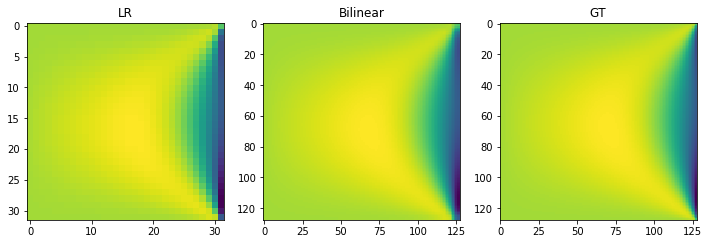

In [22]:
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(img[0,...])
plt.title('LR')

plt.subplot(132)
plt.imshow(bil_img[0,...])
plt.title('Bilinear')

plt.subplot(133)
plt.imshow(gt[0,...])
plt.title('GT')

In [26]:
print(np.power(bil_img-gt,2).mean())
bil_bc = bil_img.copy()
bil_bc[...,-1] = gt[...,-1]
print(np.power(bil_bc-gt,2).mean())

8.575136238594947e-05
8.389505850652444e-05


# Generate HF data, no BC

In [43]:
LR_tensor = torch.Tensor(LR_data)
BIL_data = upsample(LR_tensor,mode='bilinear',scale_factor=4).numpy()

BIL_data[...,-1] = HR_data[...,-1]
print(BIL_data.shape)
print(np.power(HR_data-BIL_data,2).mean(axis=(0,2,3)))

D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(400, 4, 128, 128)
[1.73400883e-04 4.49892743e-05 1.24562373e-10 1.08962941e-10]


In [44]:
HF_res = HR_data - BIL_data

In [45]:
hf = h5py.File('SR4_Data_bc.h5','w')
hf.create_dataset('training_data', data=BIL_data, compression="gzip")
hf.create_dataset('training_labels', data=HF_res, compression="gzip")

hf.close()

# Generate HFx4 test data, no BC

In [46]:
matdata = sio.loadmat('SR_test_quaddata.mat')
HR_data = matdata['HR_data']
LR_data = HR_data[:,:,::4,3::4]


In [47]:
LR_tensor = torch.Tensor(LR_data)
BIL_data = upsample(LR_tensor,mode='bilinear',scale_factor=4).numpy()
BIL_data[...,-1] = HR_data[...,-1]
print(BIL_data.shape)
print(np.power(HR_data-BIL_data,2).mean(axis=(0,2,3)))

HF_res = HR_data - BIL_data

D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(100, 4, 128, 128)
[1.54486654e-04 4.05402482e-05 1.10449610e-10 9.14435676e-11]


In [48]:
hf = h5py.File('SR4_Test_bc.h5','w')
hf.create_dataset('training_data', data=BIL_data, compression="gzip")
hf.create_dataset('training_labels', data=HF_res, compression="gzip")

hf.close()

# Convert to h5py

In [30]:
hf = h5py.File('SR_Datav2.h5', 'w')

hf.create_dataset('training_data', data=LR_data, compression="gzip")
hf.create_dataset('training_labels', data=HR_data, compression="gzip")

hf.close()

In [7]:
hf = h5py.File('SR_Data.h5', 'w')

hf.create_dataset('training_data', data=LR_data, compression="gzip")
hf.create_dataset('training_labels', data=HR_data, compression="gzip")

<HDF5 dataset "training_labels": shape (400, 4, 128, 128), type "<f8">

In [15]:
hf.close()

# Read in Data

In [41]:
sr_data = h5py.File('SR4_Test_no_bc.h5','r')

In [34]:
training_data = sr_data['training_data']
print(training_data.shape)

(400, 4, 128, 128)


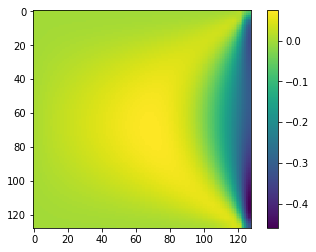

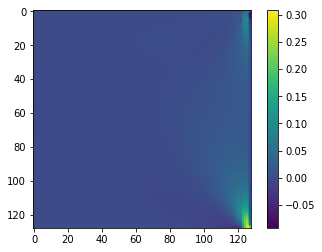

In [35]:
plt.figure()
plt.imshow(sr_data['training_data'][0,0])
plt.colorbar()

plt.figure()
plt.imshow(sr_data['training_labels'][0,0])
plt.colorbar()

In [42]:
print(np.mean(np.power(sr_data['training_labels'][:,0,...],2))*1e6)

157.83093603057108


In [16]:
qtestdata = h5py.File('SR_Test_Quad_Data.h5','r')
qtestinputs = qtestdata['test_data']
qtestlabels = qtestdata['test_labels']

In [ ]:
net = 

In [19]:
n=100
# Naive Solution
naive_mses = np.zeros((n,4))
dumb_mses = np.zeros((n,4))
mask = np.array([[1,0],[0,0]])
for i in range(n):
    labels = qtestlabels[i]
    output = np.zeros(labels.shape)
    dumb = np.zeros(labels.shape)
    for j in range(4):
        output[j] = np.kron(qtestinputs[i,j],np.ones((2,2)))
    dumb[:,::2,::2] = qtestinputs[i]
    
    naive_mses[i] = np.mean(np.mean(np.power(output-labels,2),-2),-1)
    dumb_mses[i] = np.mean(np.mean(np.power(dumb-labels,2),-2),-1)

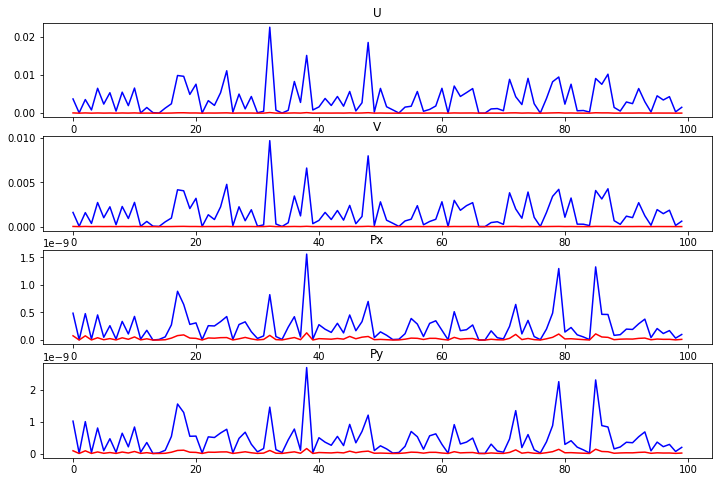

In [20]:
plt.figure(figsize=(12,8))
channels = ['U','V','Px','Py']
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.plot(dumb_mses[:,i],'b')
    plt.plot(naive_mses[:,i],'r')
    plt.title(channels[i])
plt.show()